# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con etiquetado para construir un modelo que clasifique las reseñas como positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Instrucciones del proyecto

1. Carga los datos.
2. Preprocesa los datos, si es necesario.
3. Realiza un análisis exploratorio de datos y haz tu conclusión sobre el desequilibrio de clases.
4. Realiza el preprocesamiento de datos para el modelado.
5. Entrena al menos tres modelos diferentes para el conjunto de datos de entrenamiento.
6. Prueba los modelos para el conjunto de datos de prueba.
7. Escribe algunas reseñas y clasifícalas con todos los modelos.
8. Busca las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores. Intenta explicarlas.
9. Muestra tus hallazgos.

## Descripción de los datos

Los datos se almacenan en el archivo imdb_reviews.tsv.

Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).

Aquí se describen los campos seleccionados:

* review: el texto de la reseña
* pos: el objetivo, '0' para negativo y '1' para positivo
* ds_part: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

Hay otros campos en el conjunto de datos, puedes explorarlos si lo deseas.

## Evaluación de proyecto

Hemos recopilado los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio:

* Cargaste y preprocesaste los datos de texto para su vectorización.
* Transformaste los datos de texto en vectores.
* Definiste, entrenaste y probaste los modelos.
* Se alcanzó el umbral de la métrica.
* Colocaste todas las celdas de código en el orden de su ejecución.
* Puedes ejecutar sin errores todas las celdas de código.
* Sacaste conclusiones.

## Inicialización

In [54]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

import spacy

import torch
import transformers


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

#plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})


## EDA

In [5]:
# mostrar información del DataFrame
def info(df):
    display(df.sample(10))
    print()
    print(df.info())
    print()
    print(df.describe())
    print()
    print('Duplicated: ',df.duplicated().sum())
    print()
    print('Null values %:')
    print(100*df.isnull().sum()/len(df))


In [6]:
info(df_reviews)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
10033,tt0388888,movie,Dig!,Dig!,2004,\N,107,0,"Documentary,Music",7.8,5909,Rock n' roll is a messy business and DiG! demo...,7,pos,1,train,8993
44120,tt0410799,short,Tran Scan,Tran Scan,2004,\N,8,0,"Adventure,Documentary,Short",7.8,12,I picked up TRAN SCAN from the library and bro...,1,neg,0,train,4828
33865,tt0983782,tvSeries,Thank God You're Here,Thank God You're Here,2007,\N,\N,0,"Comedy,Game-Show,Reality-TV",6.0,571,This show is terrible. I cannot get over the c...,1,neg,0,test,9386
6256,tt0115813,movie,Campfire Tales,Campfire Tales,1997,\N,88,0,Horror,5.9,3618,"This movie is so awesome! I loved it, it was r...",10,pos,1,test,7359
22651,tt0365514,movie,Moon Child,Moon Child,2003,\N,120,0,"Action,Drama,Sci-Fi",6.4,1960,I am extremely picky about the films I see. I'...,10,pos,1,train,2503
14333,tt0043581,short,Gerald McBoing-Boing,Gerald McBoing-Boing,1950,\N,8,0,"Adventure,Animation,Comedy",7.0,1709,During the brief Golden Age of the Super 8 Mag...,10,pos,1,test,2738
38727,tt0084234,movie,The Last American Virgin,The Last American Virgin,1982,\N,92,0,"Comedy,Drama,Romance",6.3,7613,Ahhh...the '80's. 1982 makes me think back to ...,7,pos,1,test,10448
24707,tt0171580,movie,Nurse Betty,Nurse Betty,2000,\N,110,0,"Comedy,Crime,Drama",6.1,32521,A wildly uneven film where the major problem i...,4,neg,0,test,656
36497,tt0819714,movie,The Edge of Love,The Edge of Love,2008,\N,110,0,"Biography,Drama,Romance",6.3,16133,Given that Dylan Thomas is an icon of modern A...,7,pos,1,test,991
37739,tt0443527,movie,The Hamiltons,The Hamiltons,2006,\N,86,0,"Drama,Horror,Thriller",5.1,8353,"This is the first of these ""8 Films To Die For...",4,neg,0,train,5183



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1)

In [7]:
df_reviews.dropna(inplace=True)

<div class="alert alert-block alert-info">
<b>

### Descripción de los datos

1. 47331 entradas
2. No hay datos duplicados
3. 0.004226%  de datos nulos en *average_rating* y *votes*. Se eliminaron        


</b></div>

Veamos el número de películas y reseñas a lo largo de los años.

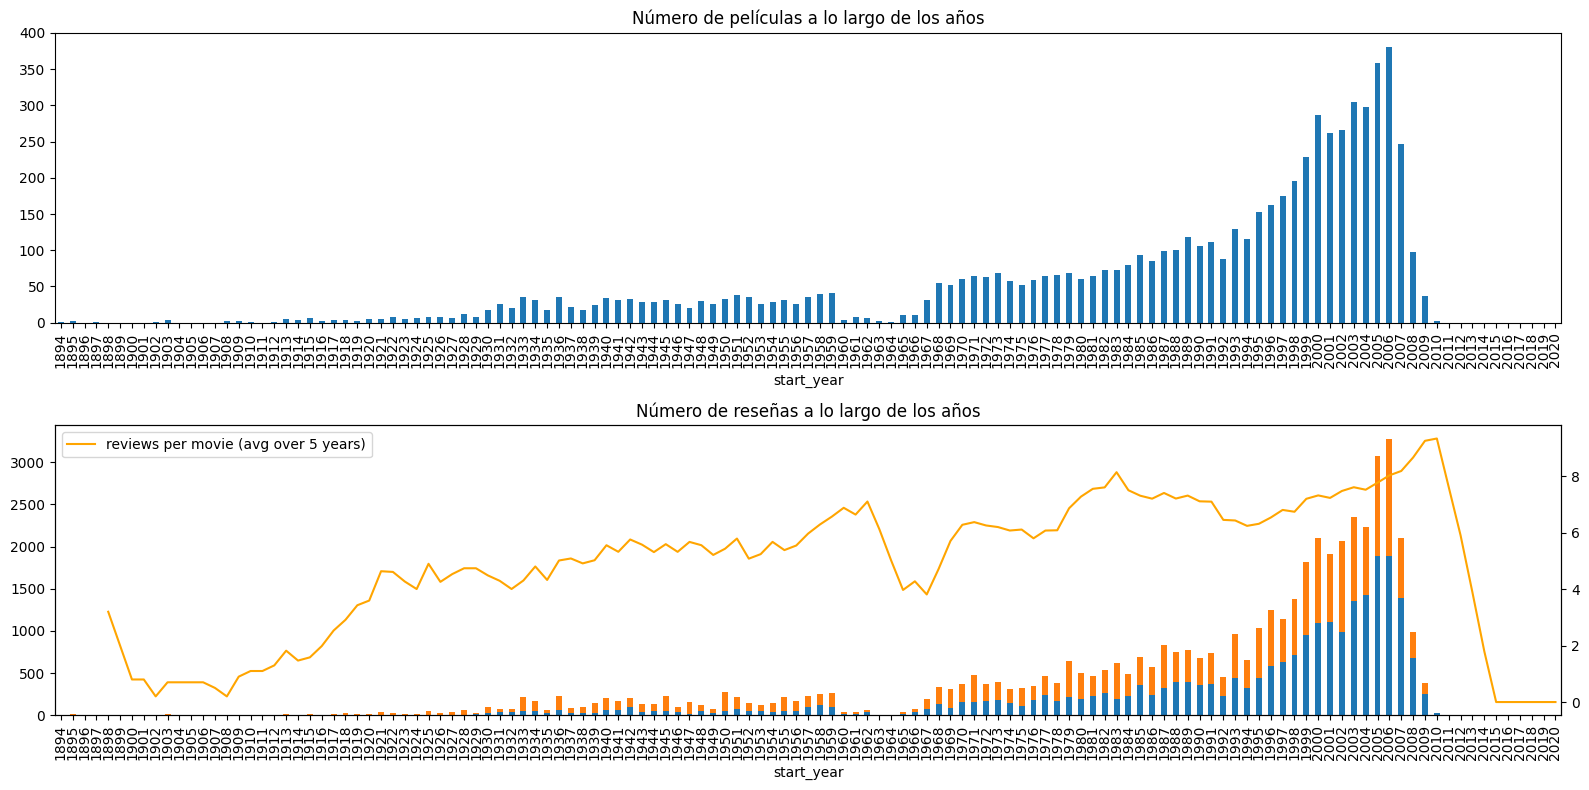

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

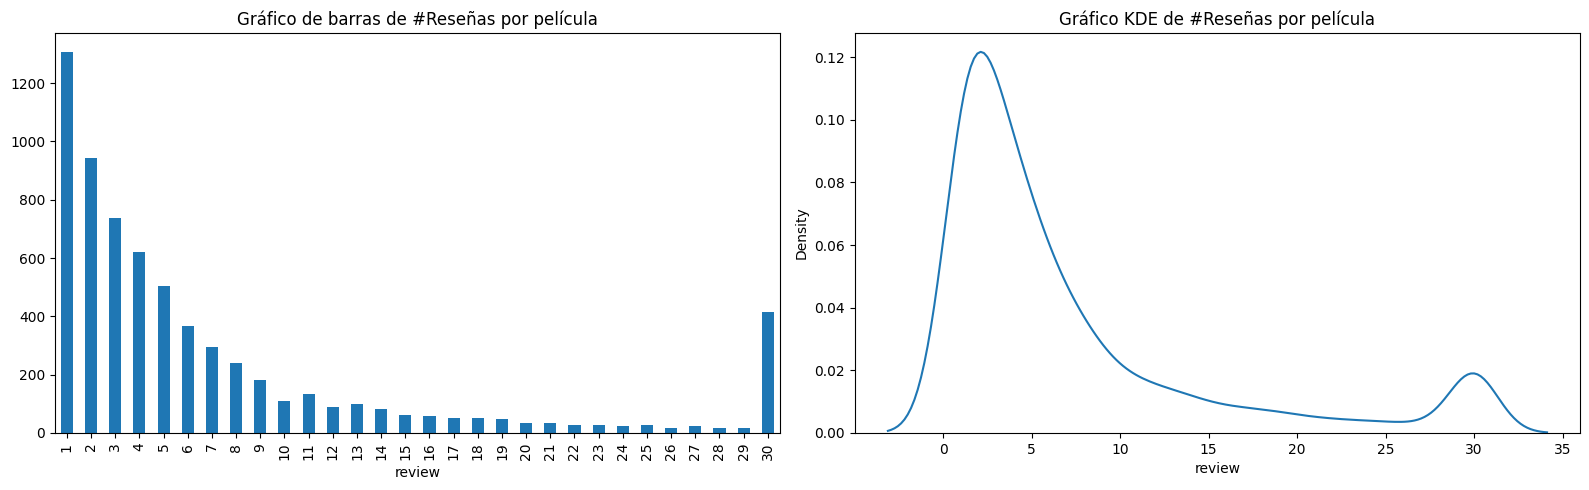

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [10]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

<div class="alert alert-block alert-info">
<b>

### Descripción de las reseñas

1. Número de reseñas de películas aumenta a lo largo de los años, siendo 2006 el año con mas reseñas
2. Promedio de 5 reseñas por película
3. Reseñas (positivas/negativas) balanceada


</b></div>

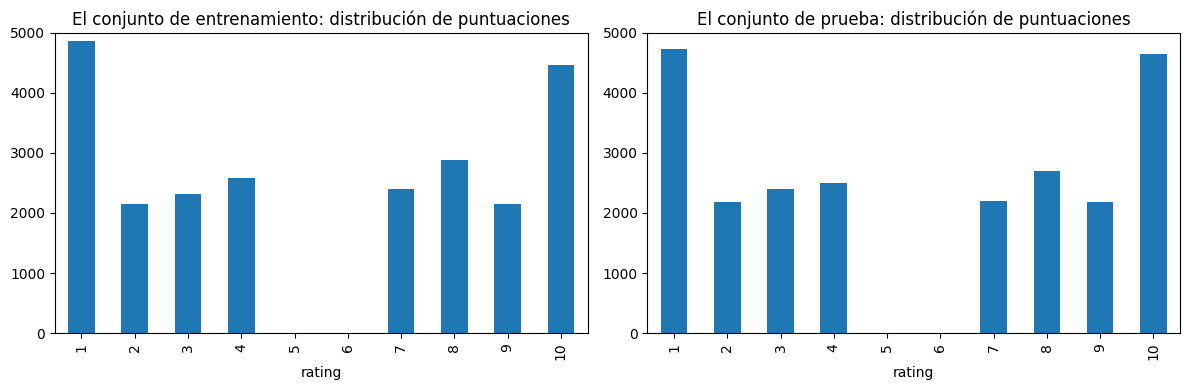

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

<div class="alert alert-block alert-info">
<b>

### Descripción de las reseñas

1. Conjutos de entrenamiento y prueba similares
2. Mas calificaciones de 1 y 10
3. Sin calificaciones intermedias (5,6)


</b></div>

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

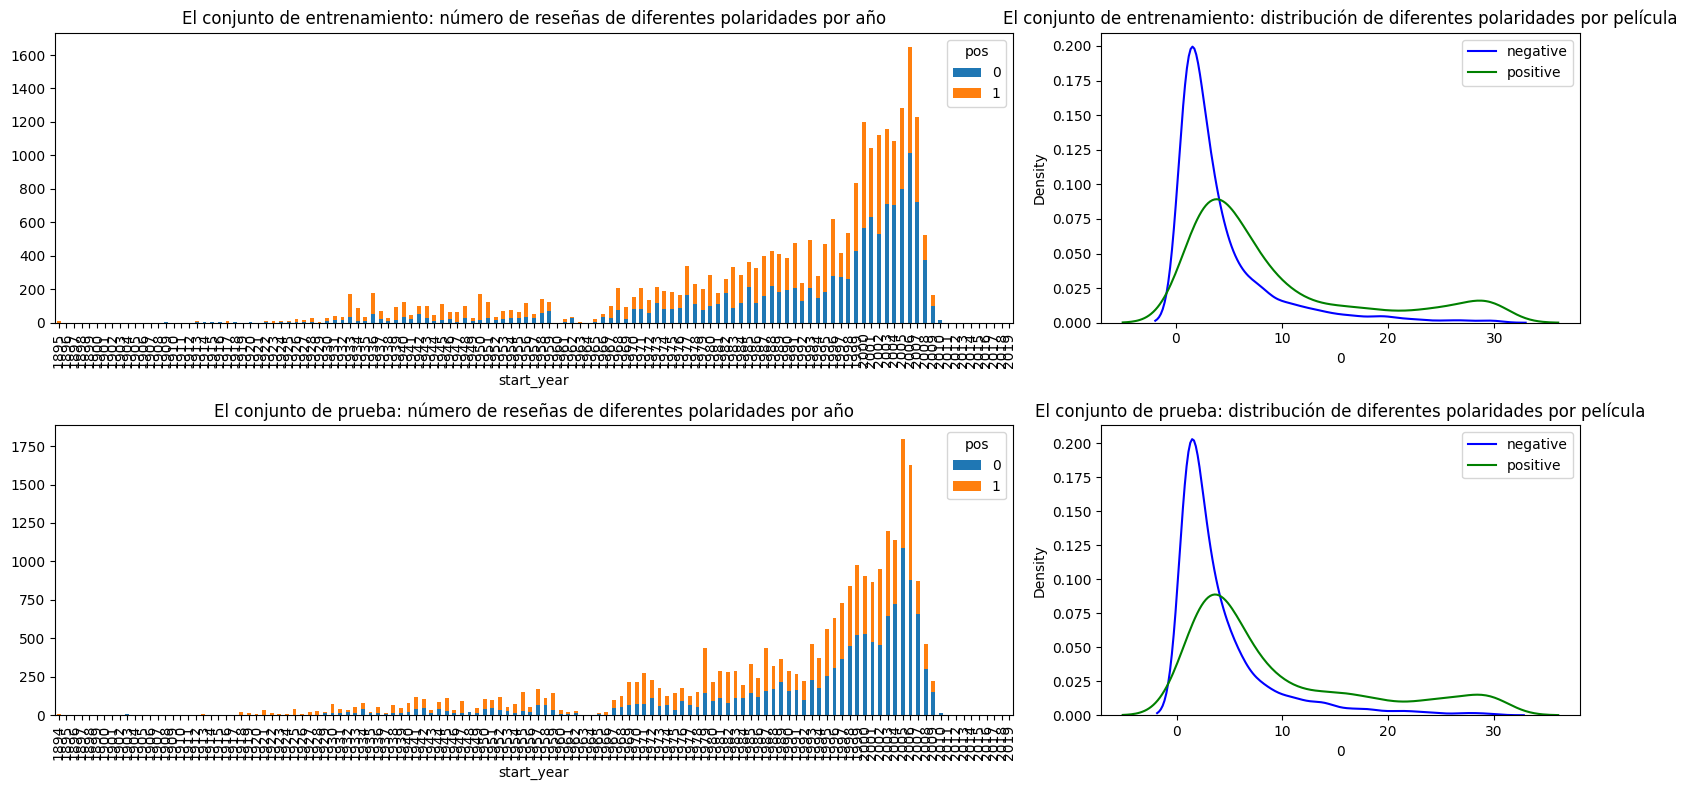

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative',  ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
   
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')   
        
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return eval_stats['train']['F1'], eval_stats['test']['F1']


## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')


In [15]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made?! presenti...
2        there is no real story the film seems more lik...
3        um .... a serious film about troubled teens in...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos. it sp...
47327    talk about being boring! i got this expecting ...
47328    i never thought i'd say this about a biopic, b...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief. this was a joy to watch....
Name: review_norm, Length: 47329, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']


## Trabajar con modelos

### Modelo 0 - Constante

           train  test
Exactitud   0.50  0.50
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


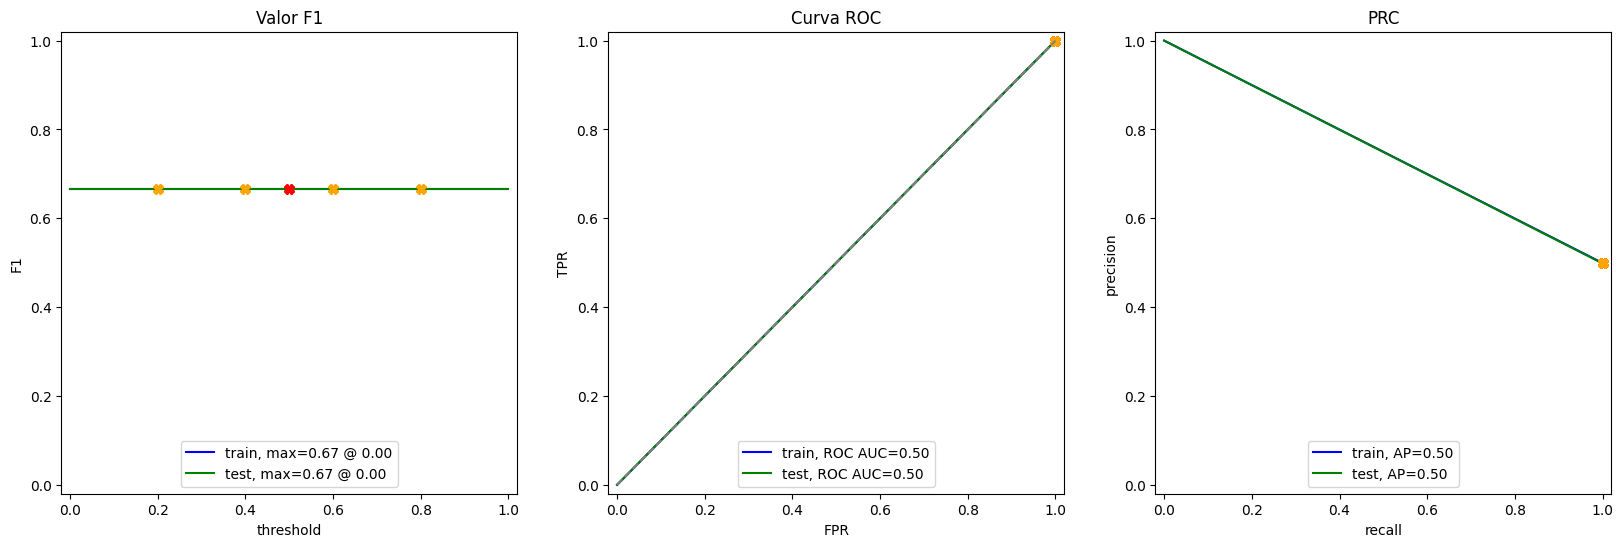

In [17]:
dummy_elf = DummyClassifier(strategy='constant', constant=1)
model_0 = dummy_elf.fit(X=df_reviews_train, y=train_target)
f1_train_0, f1_test_0 = evaluate_model(model_0, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [18]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

In [56]:
#GridSearch para encontrar los mejores hiperparámetros LogisticRegression

def find_best_params_lr(train_features, train_target):
    parameters = {
        'penalty': ['l1', 'l2'], 
        'solver': ['liblinear', 'saga'],
        'C': [0.1, 1.0]
    }
    
    nltk_lr = GridSearchCV(LogisticRegression(random_state=12345),
                           param_grid=parameters,
                           scoring='f1',
                           cv=3
                           )
    nltk_lr.fit(train_features, train_target)
    
    best_params = nltk_lr.best_params_
    best_score = nltk_lr.best_score_
    
    return best_params, best_score

In [57]:
best_params_1, best_score_1 = find_best_params_lr(train_features_1, train_target)
print('Best params:', best_params_1)
print('Best score:', best_score_1)

Best params: {'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.8711930868527031


In [58]:
model_1 = LogisticRegression(**best_params_1)
model_1.fit(train_features_1, train_target)

LogisticRegression(solver='saga')

           train  test
Exactitud   0.94  0.88
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


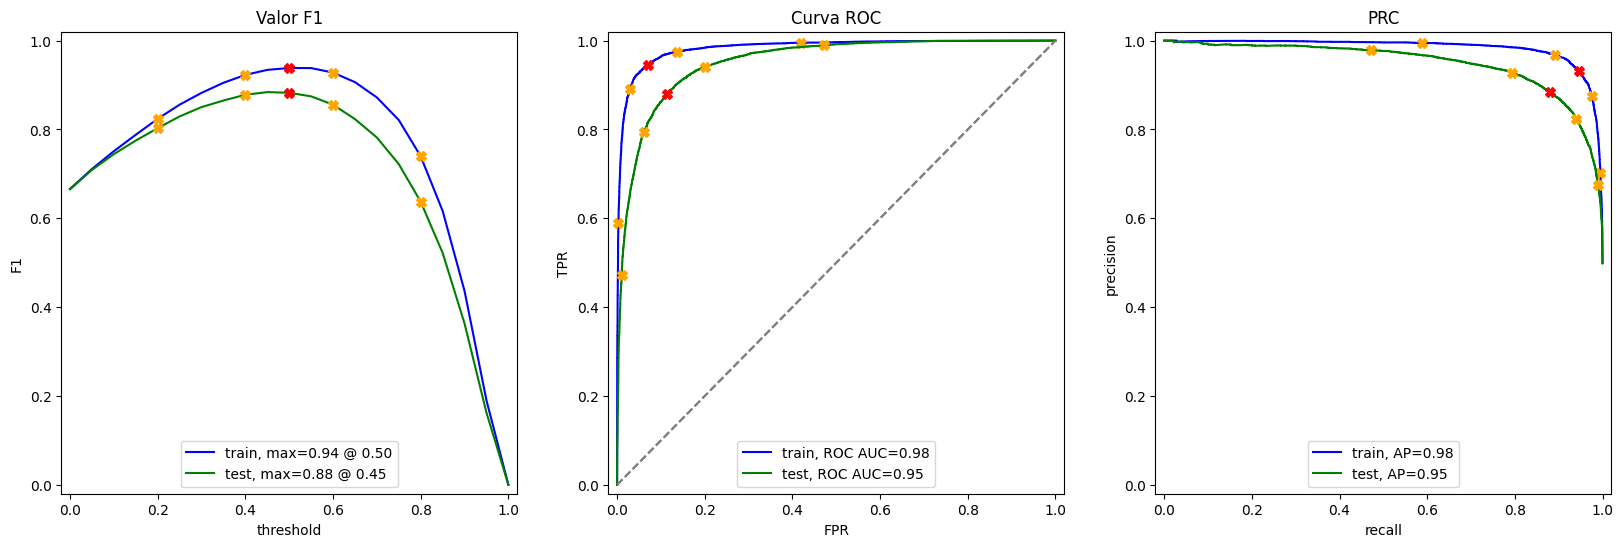

In [22]:
f1_train_1, f1_test_1 = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)


### Modelo 2 - NLTK, TF-IDF y LGBMClassifier


In [23]:
#GridSearch para encontrar los mejores hiperparámetros LGBMClassifier

def find_best_params_lightgbm(train_features, train_target):
    params_lightgbm_nltk = {
        'objective': ['binary'], 
        'num_leaves': [10, 20, 30],
        'learning_rate': [0.1, 0.2, 0.5],
        'n_estimators': [100], 
        'random_state': [12345]
    }
    
    nltk_lightgbm = GridSearchCV(LGBMClassifier(),
                                 param_grid=params_lightgbm_nltk,
                                 scoring='f1',
                                 cv=3
                                 )
    nltk_lightgbm.fit(train_features, train_target)
    
    best_params = nltk_lightgbm.best_params_
    best_score = nltk_lightgbm.best_score_
    
    return best_params, best_score


In [24]:
best_params_2, best_score_2 = find_best_params_lightgbm(train_features_1, train_target)
print(f'Hiperparámetros LightGBM: {best_params_2}')
print(f'F1 LightGBM: {best_score_2}')

[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.472593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372924
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 9027
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.002269
[LightGBM] [Info] Start training from score -0.002269
[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373839
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 9012
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.00226

/home/isadoji/Storage/github/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.984300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521069
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 11691
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
Hiperparámetros LightGBM: {'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 20, 'objective': 'binary', 'random_state': 12345}
F1 LightGBM: 0.859859965330862


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.258615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521069
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 11691
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
           train  test
Exactitud   0.93  0.86
F1          0.93  0.86
APS         0.98  0.94
ROC AUC     0.98  0.94


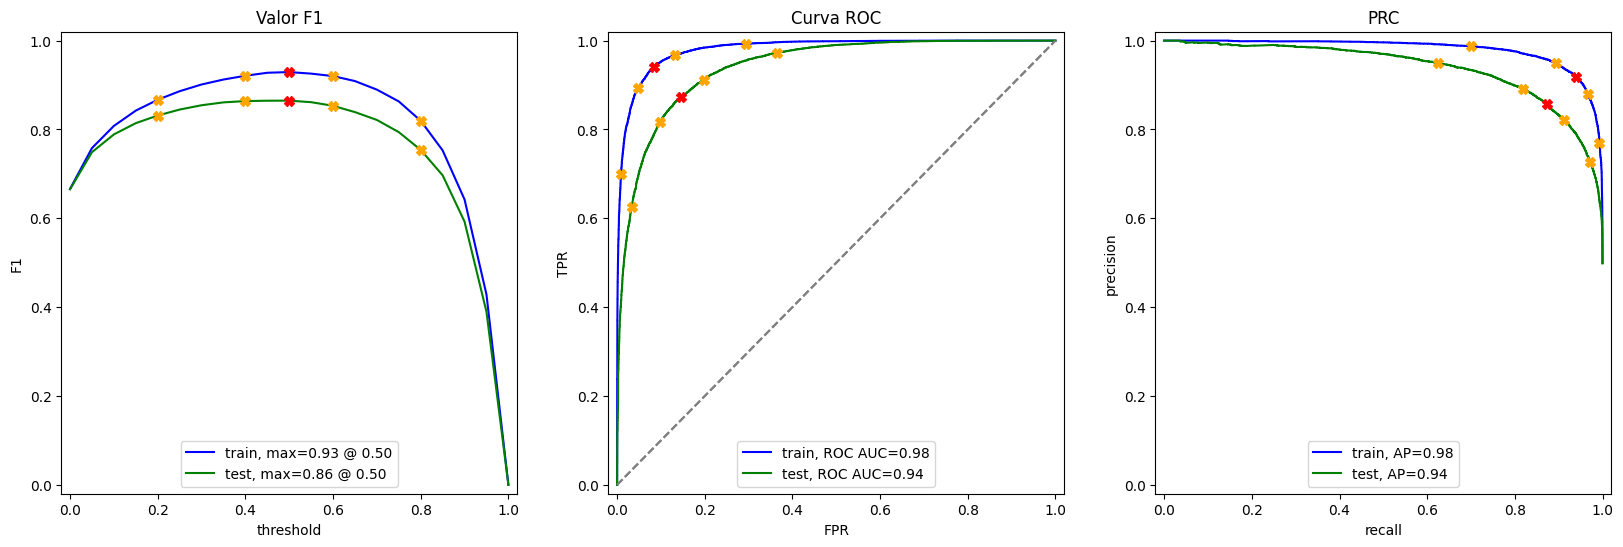

In [25]:
model_2 = LGBMClassifier(**best_params_2)
model_2.fit(train_features_1, train_target)
f1_train_2, f1_test_2 = evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [26]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):
    doc = nlp(text) 
    tokens = [token.lemma_ for token in doc] 
    return ' '.join(tokens) 

In [28]:
df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].apply(lambda x: text_preprocessing_3(x))
df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].apply(lambda x: text_preprocessing_3(x))

In [29]:

tfidf_vectorizer_3 = TfidfVectorizer()
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_tokenized_3'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_tokenized_3'])


           train  test
Exactitud   0.93  0.88
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


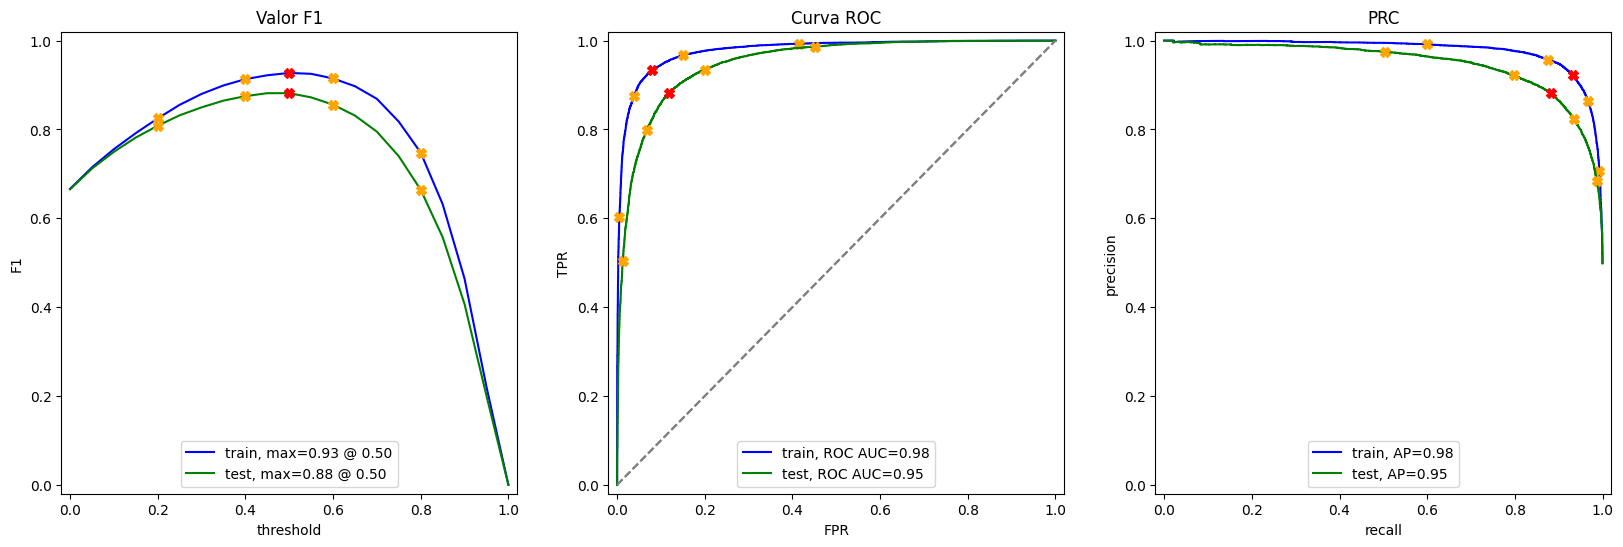

In [59]:
best_params_3, best_score_3 = find_best_params_lr(train_features_3, train_target)
model_3 = LogisticRegression(**best_params_3)
model_3.fit(train_features_3, train_target)
f1_train_3, f1_test_3 = evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.360939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361884
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 7556
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.002269
[LightGBM] [Info] Start training from score -0.002269
[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.382821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363011
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 7584
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.00226

/home/isadoji/Storage/github/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.717613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486676
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.669727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 486676
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.0

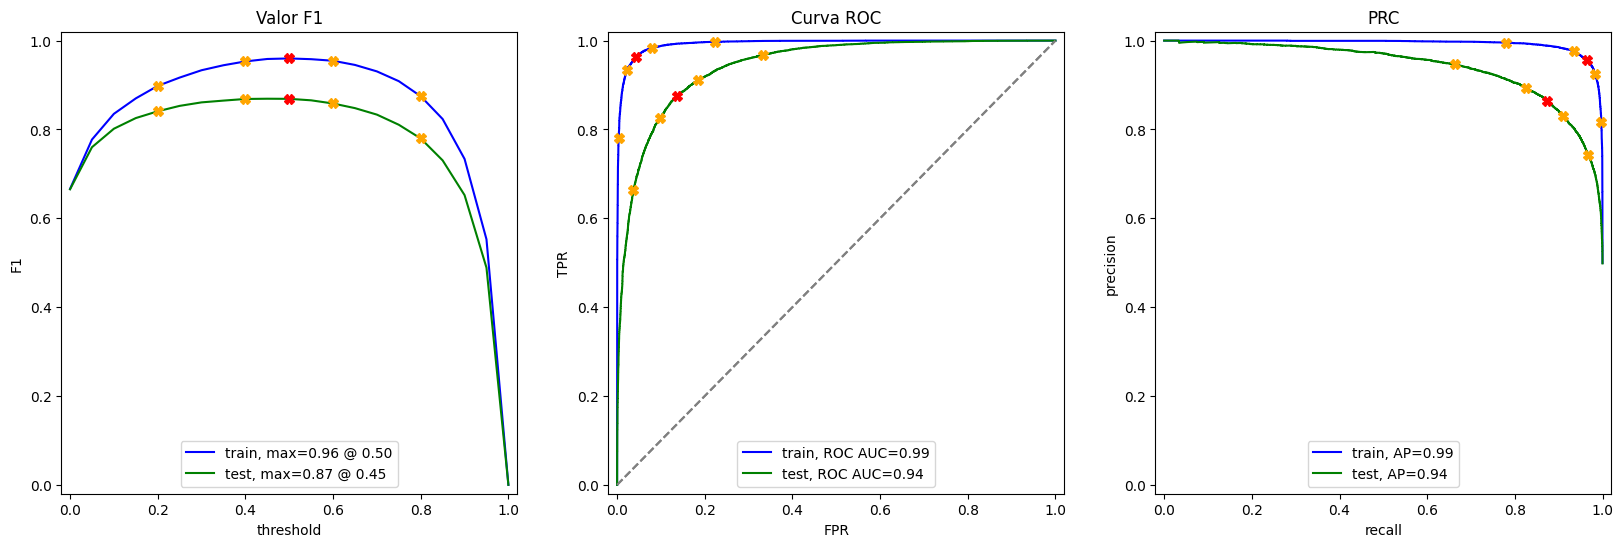

In [31]:
best_params_4, best_score_4 = find_best_params_lightgbm(train_features_3, train_target)
model_4 = LGBMClassifier(**best_params_4)
model_4.fit(train_features_3, train_target)
f1_train_4, f1_test_4 = evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Modelo 5 - BERT LR

In [32]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [33]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    # Convert lists to numpy arrays
    ids_array = np.array(ids_list)
    attention_mask_array = np.array(attention_mask_list)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Use {device} device.')

    # get embedding in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)

        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [34]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_5 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

  0%|          | 0/23796 [00:00<?, ?it/s]

Use cuda device.


  0%|          | 0/238 [00:00<?, ?it/s]

/tmp/ipykernel_34949/1957117004.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [35]:
test_features_5 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

  0%|          | 0/23533 [00:00<?, ?it/s]

Use cuda device.


  0%|          | 0/236 [00:00<?, ?it/s]

In [36]:
np.savez_compressed('features_5.npz', train_features_5=train_features_5, test_features_5=test_features_5)
with np.load('features_5.npz') as data:
     train_features_5 = data['train_features_5']
     test_features_5 = data['test_features_5']

/home/isadoji/Storage/github/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isadoji/Storage/github/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isadoji/Storage/github/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isadoji/Storage/github/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/isadoji/Storage/github/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home

           train  test
Exactitud   0.89  0.88
F1          0.89  0.88
APS         0.95  0.95
ROC AUC     0.95  0.95


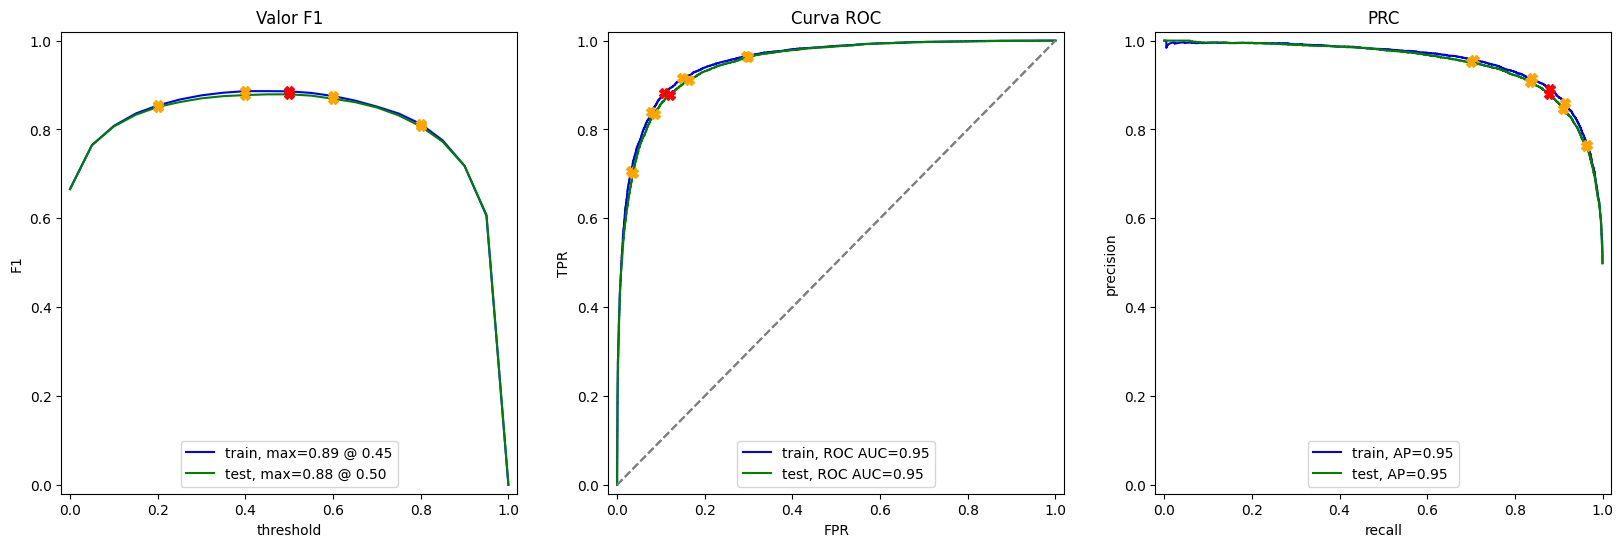

In [62]:
best_params_5, best_score_5 = find_best_params_lr(train_features_5, train_target,)
model_5 = LogisticRegression(**best_params_5)
model_5.fit(train_features_5, train_target)
f1_train_5, f1_test_5 = evaluate_model(model_5, train_features_5, train_target, test_features_5, test_target)

###  Modelo 6 - BERT LGBMClassifier

[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.002269
[LightGBM] [Info] Start training from score -0.002269
[LightGBM] [Info] Number of positive: 7923, number of negative: 7941
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 15864, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499433 -> initscore=-0.002269
[LightGBM] [Info] Start training from score -0.002269
[LightGBM]

/home/isadoji/Storage/github/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
      

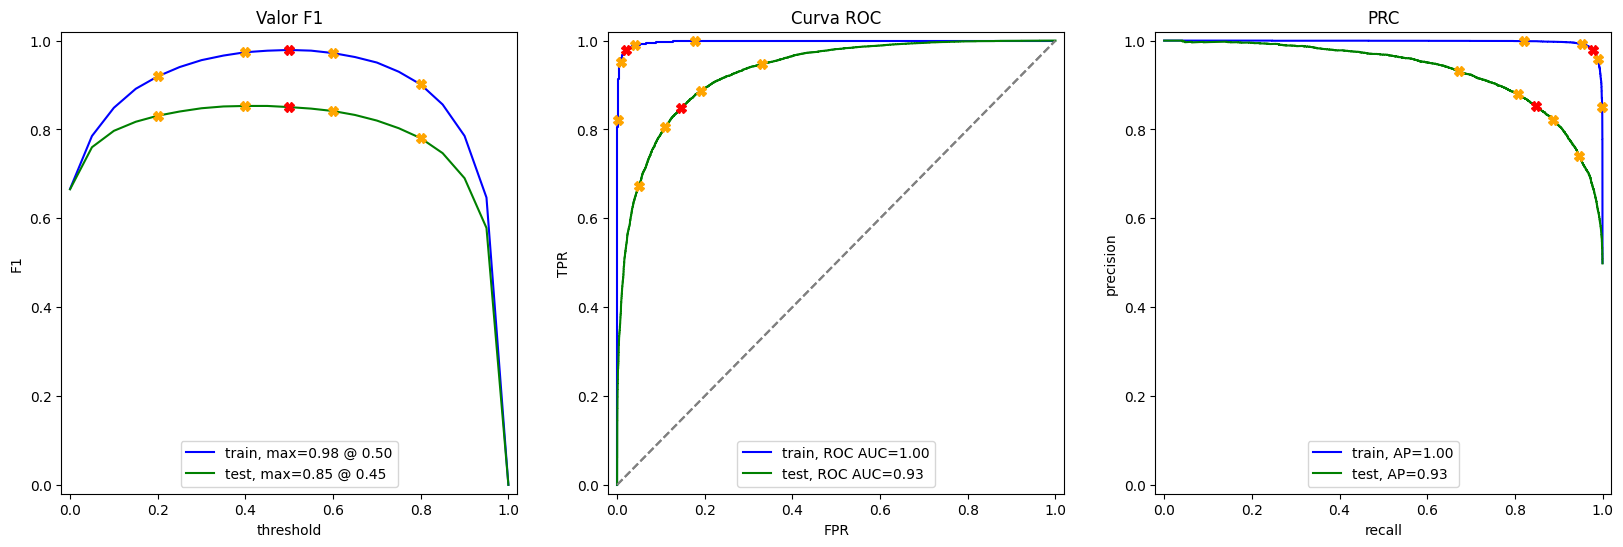

In [38]:
best_params_6, best_score_6 = find_best_params_lightgbm(train_features_5, train_target)
model_6 = LGBMClassifier(**best_params_6)
model_6.fit(train_features_5, train_target)
f1_train_6, f1_test_6 = evaluate_model(model_6, train_features_5, train_target, test_features_5, test_target)

## Mis reseñas

In [65]:
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])


my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: text_preprocessing_3(x))
my_reviews

,review,review_norm
0,"Simplemente no me gustó, no es mi tipo de pelí...","simplemente no me gustó , no es mi tipo de pel..."
1,"Bueno, estaba aburrido y me quedé dormido a me...","Bueno , estaba aburrido y me quedé dormido a m..."
2,Estaba realmente fascinada con la película,Estaba realmente fascinada con la película
3,Hasta los actores parecían muy viejos y desint...,Hasta los actore parecían muy viejos y desinte...
4,¡No esperaba que el relanzamiento fuera tan bu...,¡ no esperaba que el relanzamiento fuera tan b...
5,"La película tuvo sus altibajos, pero siento qu...","La película tuvo sus altibajos , pero siento q..."
6,Qué pésimo intento de comedia. Ni una sola bro...,Qué pésimo intento de comedia . Ni una sola br...
7,Fue muy valiente el lanzamiento en Netflix y r...,Fue muy valiente el lanzamiento en Netflix y r...


### Modelo 2

In [66]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.49:  simplemente no me gustó , no es mi tipo de película .
0.44:  Bueno , estaba aburrido y me quedé dormido a medium película .
0.61:  Estaba realmente fascinada con la película
0.48:  Hasta los actore parecían muy viejos y desinteresados , y les pagaron por estar en la película . Qué
0.36:  ¡ no esperaba que el relanzamiento fuera tan bueno ! Los escritore realmente se preocuparon por el m
0.53:  La película tuvo sus altibajos , pero siento que , en general , es una película decente . Sí la volv
0.54:  Qué pésimo intento de comedia . Ni una sola broma tiene sentido , todo actúan de forma irritante y r
0.54:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


### Modelo 2

In [67]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  simplemente no me gustó , no es mi tipo de película .
0.61:  Bueno , estaba aburrido y me quedé dormido a medium película .
0.65:  Estaba realmente fascinada con la película
0.61:  Hasta los actore parecían muy viejos y desinteresados , y les pagaron por estar en la película . Qué
0.41:  ¡ no esperaba que el relanzamiento fuera tan bueno ! Los escritore realmente se preocuparon por el m
0.61:  La película tuvo sus altibajos , pero siento que , en general , es una película decente . Sí la volv
0.61:  Qué pésimo intento de comedia . Ni una sola broma tiene sentido , todo actúan de forma irritante y r
0.61:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


### Modelo 3

In [68]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.25:  simplemente no me gustó , no es mi tipo de película .
0.55:  Bueno , estaba aburrido y me quedé dormido a medium película .
0.58:  Estaba realmente fascinada con la película
0.48:  Hasta los actore parecían muy viejos y desinteresados , y les pagaron por estar en la película . Qué
0.26:  ¡ no esperaba que el relanzamiento fuera tan bueno ! Los escritore realmente se preocuparon por el m
0.51:  La película tuvo sus altibajos , pero siento que , en general , es una película decente . Sí la volv
0.54:  Qué pésimo intento de comedia . Ni una sola broma tiene sentido , todo actúan de forma irritante y r
0.54:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


### Modelo 4

In [69]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.38:  simplemente no me gustó , no es mi tipo de película .
0.54:  Bueno , estaba aburrido y me quedé dormido a medium película .
0.54:  Estaba realmente fascinada con la película
0.54:  Hasta los actore parecían muy viejos y desinteresados , y les pagaron por estar en la película . Qué
0.29:  ¡ no esperaba que el relanzamiento fuera tan bueno ! Los escritore realmente se preocuparon por el m
0.54:  La película tuvo sus altibajos , pero siento que , en general , es una película decente . Sí la volv
0.54:  Qué pésimo intento de comedia . Ni una sola broma tiene sentido , todo actúan de forma irritante y r
0.54:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


### Modelo 5

In [70]:
texts = my_reviews['review_norm']

my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_5)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.70:  simplemente no me gustó , no es mi tipo de película .
0.77:  Bueno , estaba aburrido y me quedé dormido a medium película .
0.41:  Estaba realmente fascinada con la película
0.49:  Hasta los actore parecían muy viejos y desinteresados , y les pagaron por estar en la película . Qué
0.61:  ¡ no esperaba que el relanzamiento fuera tan bueno ! Los escritore realmente se preocuparon por el m
0.92:  La película tuvo sus altibajos , pero siento que , en general , es una película decente . Sí la volv
0.99:  Qué pésimo intento de comedia . Ni una sola broma tiene sentido , todo actúan de forma irritante y r
0.73:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


### Modelo 6

In [71]:
texts = my_reviews['review_norm']

my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_6.predict_proba(my_reviews_features_5)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.90:  simplemente no me gustó , no es mi tipo de película .
0.85:  Bueno , estaba aburrido y me quedé dormido a medium película .
0.79:  Estaba realmente fascinada con la película
0.81:  Hasta los actore parecían muy viejos y desinteresados , y les pagaron por estar en la película . Qué
0.78:  ¡ no esperaba que el relanzamiento fuera tan bueno ! Los escritore realmente se preocuparon por el m
0.97:  La película tuvo sus altibajos , pero siento que , en general , es una película decente . Sí la volv
0.97:  Qué pésimo intento de comedia . Ni una sola broma tiene sentido , todo actúan de forma irritante y r
0.92:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


<div class="alert alert-block alert-info">
<b>

## Conclusiones

1. El modelo 1 de regresión logística con NLTK logró predecir 
correctamente 6 de las 8 reseñas, falló al intentar predecir 
dos críticas positivas con palabras negativas.

2. El modelo 2 de LightGBM con NLTK logró predecir correctamente 
5 de las 8 reseñas, falló al clasificar una crítica negativa y 
una crítica positiva. 

3. El modelo 3 de regresión logística con spaCy logró predecir 
correctamente 5 de las 8 reseñas, falló al clasificar 3 de las 4 críticas 
positivas.

4. El modelo 4 de potenciación de gradiente con spaCy logro predecir 
correctamente 7 de las 8 reseñas, falló al clasificar una crítica negativa
como positiva.

5. El modelo 5 de regresión logística con BERT logro predecir 
correctamente 7 de las 8 reseñas, falló al clasificar una crítica positiva
como negativa.

6. El modelo 6 de potenciación de gradiente con BERT realizó la predicción 
correcta de 7 de 8 reseñas, falló al clasificar una crítica positiva
como negativa.

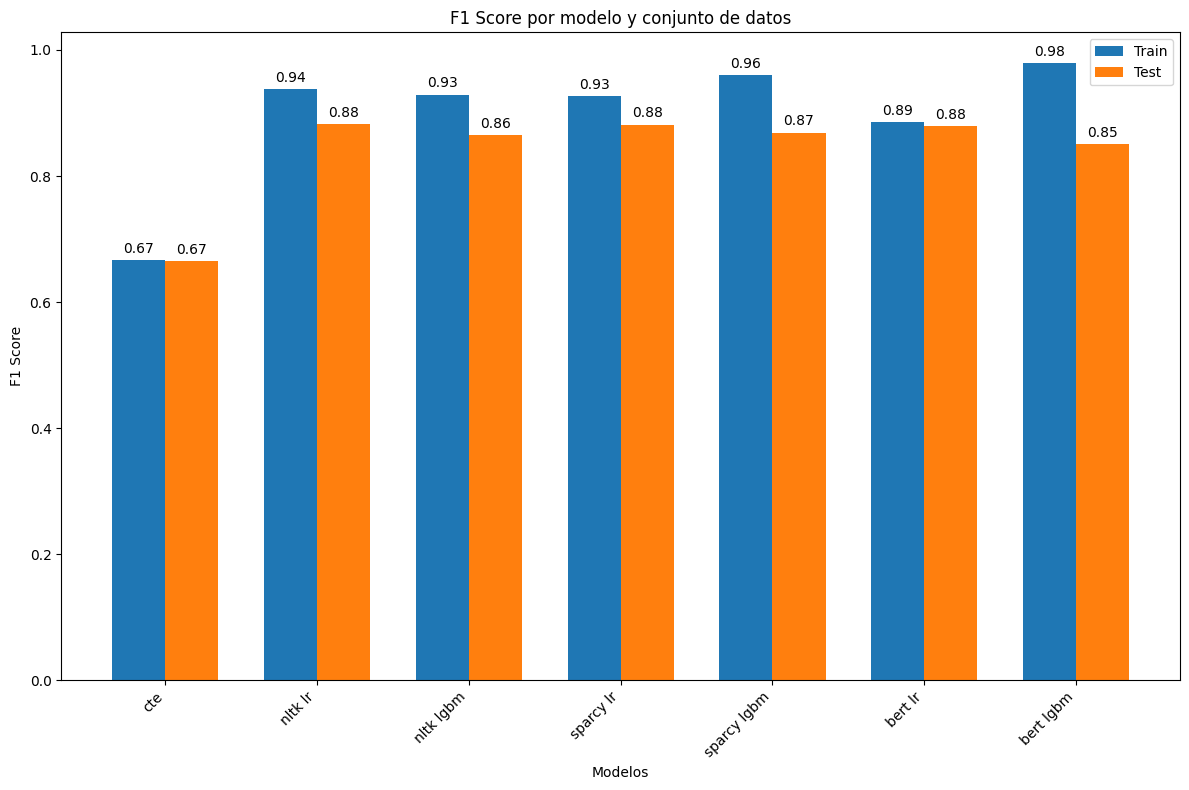

In [72]:
f1_train_values = [f1_train_0, f1_train_1, f1_train_2, f1_train_3, f1_train_4, f1_train_5, f1_train_6]
f1_test_values = [f1_test_0, f1_test_1, f1_test_2, f1_test_3, f1_test_4, f1_test_5, f1_test_6]

model_names = ['cte', 'nltk lr', 'nltk lgbm', 'sparcy lr', 'sparcy lgbm', 'bert lr', 'bert lgbm']
x = np.arange(len(model_names))  
width = 0.35 

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, f1_train_values, width, label='Train')
rects2 = ax.bar(x + width/2, f1_test_values, width, label='Test')

ax.set_xlabel('Modelos')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score por modelo y conjunto de datos')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

<div class="alert alert-block alert-info">
<b>

## Conclusiones

### MEJOR MODELO: 

Los modelos fueron evaluados a partir del puntaje F1:

1. Los modelos de regresión logística preprocesados con spaCy, NLTK y Bert son los que registraron el puntaje más alto: F1=0.88 en los conjuntos de prueba.
2. Los modelos de potenciación de gradiente, mostraron un rendimiento inferior para las tres técnicas, siendo el más bajo BERT, con F1=0.85
</b></div>